# How-to for the Sliding Window Algorithm

This notebook shows how to load a pre-trained model and run the sliding window algorithm to run object detection on a complex scene containing several objects. 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import cv2
import glob, os

import data.data_helpers as data_helpers
import models.model_helpers as model_helpers

print(tf.__version__)

2.3.0


## Get the data

 - First, we load the base dataframe which points to all images in the __validation set__. We have to use the validation set here, to get an unbiased overall score of end-to-end object recognition pipeline.
 
  - For validation, we use a two-fold approach: 
     - Validation on an artifically generated dataset with randomized objects from the validation set.
     - Validation on completely unseend images, realistic fridge scenes which were manually selected before. 
 
 
 - We could theoretically, use base dataframe, to generate a new artificial dataset with randomize object positions (this is shown in the commented block). Alternatively, artifical datasets can be created with the script *data/generate_artifical_validation_set.py*
 
 - Instead of generating a new artificial dataset here, we just load one which is already contained in the folder *data/validation_artificial*.
 


In [2]:
# define base data frame

data_directories = [
    'data/FIDS30',
    'data/original_clean',
    'data/update_9sep'
]

test_size = 0.1
seed = 11

# get base data frame and all class names
_, data_df_test, classes, class2ind, ind2class = \
data_helpers.get_train_test_data_df(data_directories, test_size, seed)

# get validation set with "real" fridge scenes
val_real_data = data_helpers.get_validation_dict('data/validation_real/', classes, verbose=0)

# get validation set with "artificial" fridge scenes
val_artificial_data = data_helpers.get_validation_dict('data/validation_artificial/', classes, verbose=0)

In [3]:
### GENERATE NEW ARTIFICIAL VALIDATION SET

#N_samples = 10
#N_min = 5
#N_max = 10
#spacing = 150
#size_jitter=(0.9,1.5)
#seed = 11
#bg_path = 'data/artificial_background'

#val_artificial_data = data_helpers.generate_artifical_validation_dataset(data_df_test, bg_path, N_samples, N_min, N_max, spacing, size_jitter, seed)

Text(0.05, 0.98, 'lemon\nother\npineapple\nlime\ngrated_cheese\ncorn')

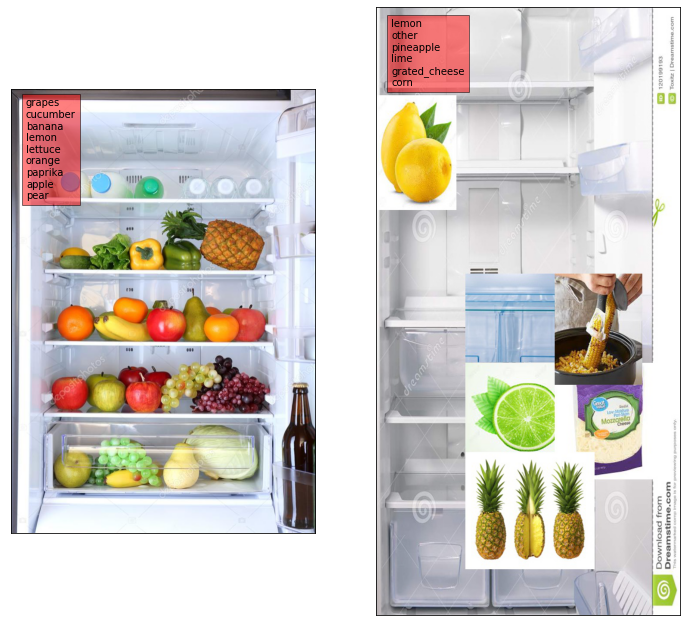

In [4]:
# show examples pictures

plt.figure(figsize=(12,12))

ax = plt.subplot(121)
plt.imshow(val_real_data[15]['image'])
plt.xticks([])
plt.yticks([])
plt.text(0.05, 0.98, '\n'.join(val_real_data[15]['labels']), 
         transform = ax.transAxes, verticalalignment='top',
         bbox=dict(facecolor='red', alpha=0.5))


ax = plt.subplot(122)
plt.imshow(val_artificial_data[15]['image'])
plt.xticks([])
plt.yticks([])
plt.text(0.05, 0.98, '\n'.join(val_artificial_data[15]['labels']), 
         transform = ax.transAxes, verticalalignment='top',
         bbox=dict(facecolor='red', alpha=0.5))

## Load model

In [5]:
from tensorflow.keras.models import Sequential, save_model, load_model

loaded_model = load_model(
    "models/test_model2",
    custom_objects=None,
    compile=True
)

## Detect objects using "image pyramid"

    - First, generate an "image pyramid", i.e. scale the given image by different factors to enable object detection of 
    differently sized objects. 
    
    - Here, for simplicity, we only use one scaling factor. (So this is not really an image pyramid)
    
    - Run non-maximum suppression on predicted boxes.
    
For more info on the "image pyramid" see, e.g.:
https://www.pyimagesearch.com/2018/05/14/a-gentle-guide-to-deep-learning-object-detection/

In [6]:
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenet_v2

# define correct pre-processing function for the network
preprocess_func = lambda x: x/255.

# define correct input size for the network (the one it was trained on)
kernel_size = 224

# define selection threshold / do not take prediction with a lesser confidence level
thr = 0.9

# select image to perform predictions on
input_sample = val_artificial_data[1]
input_sample = val_real_data[1]
img = input_sample['image']


# get predictions using the "pyramid_prediction" framework, but define only 1 scaling factor
#
# define larger scaling factors to detect smaller objects!
#
image_pyramid, pyramid_predictions, pyramid_probabilities, \
pyramid_x0, pyramid_y0, pyramid_windowsize = model_helpers.pyramid_prediction(loaded_model, 
                                                          preprocess_func, 
                                                          img, 
                                                          scaling_factors=[1.5], 
                                                          thr=thr, 
                                                          kernel_size=kernel_size, 
                                                          strides=[32])

# get predictions
predictions = pyramid_predictions[0]
probabilities = pyramid_probabilities[0]
x0 = pyramid_x0[0]
y0 = pyramid_y0[0]
windowsize = pyramid_windowsize[0]

# get label names 
pred_labels = [ind2class[i] for i in predictions]

# perform non-maximum suppression
overlap_thr = 0.1
pred_labels, probabilities, x0, y0, windowsize = model_helpers.nonmax_suppression(pred_labels, probabilities, x0, y0, windowsize, overlap_thr=overlap_thr)

## Evaluate and visualize results

Correctly identified: pear, radish, tomato
Missed items: lettuce, paprika

Precision: 75.00 %
Recall: 60.00 %


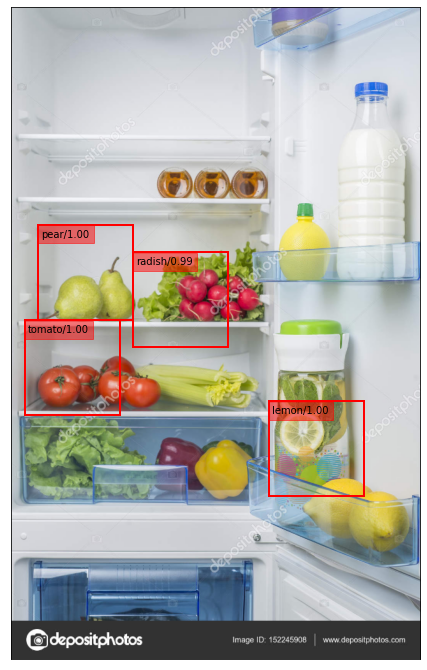

In [7]:
actual_labels = input_sample['labels']

# true positives are intersection between predicted and actual labels
TP = set(actual_labels).intersection(set(pred_labels))

# false positives are difference between predicted and actual labels
FP = set(pred_labels) - set(actual_labels)

# false negatives are difference between actual and predicted labels
FN = set(actual_labels) - set(pred_labels)

# true negatives are intersection between the differences between all classes 
# and the actual and predicted classes respectively
# (usually not so important for object detection)
TN = (set(classes) - set(actual_labels)).intersection((set(classes) - set(pred_labels)))

precision = len(TP) / (len(TP)+len(FP))
recall  = len(TP) / (len(TP)+len(FN))

print(f'Correctly identified: ' + ', '.join(TP))
print(f'Missed items: ' + ', '.join(FN))
print()
print(f'Precision: {100*precision:.2f} %')
print(f'Recall: {100*recall:.2f} %')

# visualize results
fig = model_helpers.visualize_predictions(img, 
                                          pred_labels, 
                                          probabilities, 
                                          x0, 
                                          y0,
                                          windowsize)